In [1]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.nn import init
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import time

/opt/conda/envs/SAM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 定义一个通用的FFN类
class FFN(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens_list):
        super(FFN, self).__init__()
        layers = []
        input_dim = num_inputs
        for num_hiddens in num_hiddens_list:
            layers.append(nn.Linear(input_dim, num_hiddens))
            layers.append(nn.ReLU())
            input_dim = num_hiddens
        layers.append(nn.Linear(input_dim, num_outputs))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

In [3]:
# 定义准确率函数
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [4]:
# 训练和评估函数
def train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device):
    # 记录训练时间
    start_time = time.time()
    print('Training on: ', device)
    train_loss_list, train_accuracy_list = [], []
    test_loss_list, test_accuracy_list = [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = 0, 0
        for X, y in train_loader:
            X, y = X.view(-1, 28*28).to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += accuracy(pred, y)
        
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        
        model.eval()
        test_loss, test_accuracy = 0, 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.view(-1, 28*28).to(device), y.to(device)
                pred = model(X)
                test_loss += loss_fn(pred, y).item()
                test_accuracy += accuracy(pred, y)
        
        test_loss /= len(test_loader)
        test_accuracy /= len(test_loader)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
    print('Training time: ', time.time()-start_time)
    return train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list

# 可视化结果
def show(train_loss_list, test_loss_list, train_accuracy_list=None, test_accuracy_list=None):
    plt.figure(figsize=(12, 5))
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(test_loss_list, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
     
    if train_accuracy_list != None:
        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(train_accuracy_list, label='Train Accuracy')
        plt.plot(test_accuracy_list, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.title('Accuracy over Epochs')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [5]:
# 加载数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

50890
Training on:  cuda
Epoch [1/60], Train Loss: 0.7402, Train Accuracy: 0.8206, Test Loss: 0.3604, Test Accuracy: 0.9017
Epoch [2/60], Train Loss: 0.3411, Train Accuracy: 0.9038, Test Loss: 0.3015, Test Accuracy: 0.9147
Epoch [3/60], Train Loss: 0.2951, Train Accuracy: 0.9151, Test Loss: 0.2693, Test Accuracy: 0.9237
Epoch [4/60], Train Loss: 0.2644, Train Accuracy: 0.9255, Test Loss: 0.2426, Test Accuracy: 0.9291
Epoch [5/60], Train Loss: 0.2394, Train Accuracy: 0.9321, Test Loss: 0.2222, Test Accuracy: 0.9365
Epoch [6/60], Train Loss: 0.2185, Train Accuracy: 0.9385, Test Loss: 0.2065, Test Accuracy: 0.9410
Epoch [7/60], Train Loss: 0.2012, Train Accuracy: 0.9438, Test Loss: 0.1917, Test Accuracy: 0.9425
Epoch [8/60], Train Loss: 0.1863, Train Accuracy: 0.9480, Test Loss: 0.1805, Test Accuracy: 0.9472
Epoch [9/60], Train Loss: 0.1736, Train Accuracy: 0.9513, Test Loss: 0.1664, Test Accuracy: 0.9511
Epoch [10/60], Train Loss: 0.1623, Train Accuracy: 0.9540, Test Loss: 0.1571, Test A

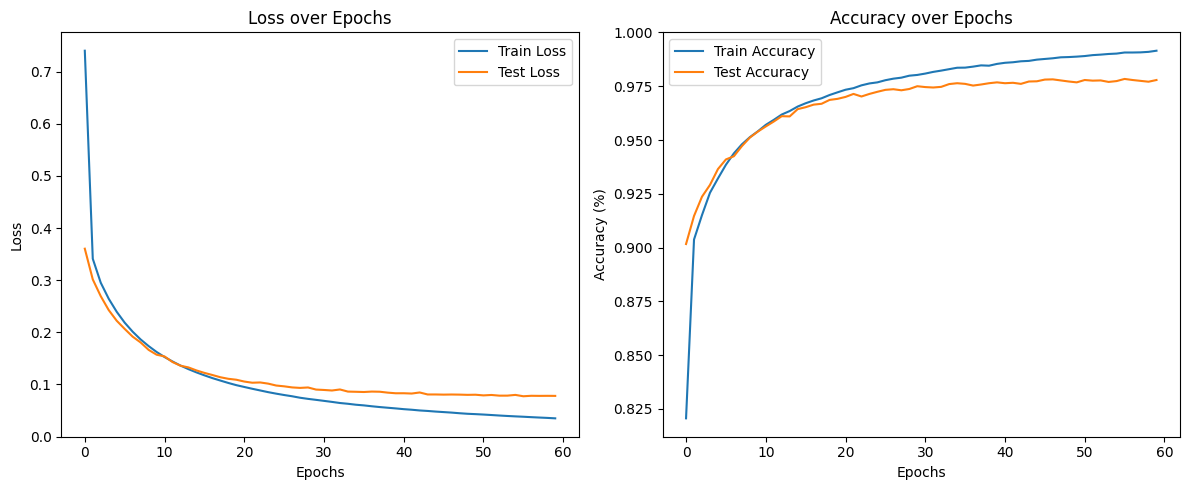

In [6]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[64]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_64, train_accuracy_list_64, test_loss_list_64, test_accuracy_list_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_64, test_loss_list_64, train_accuracy_list_64, test_accuracy_list_64)

cuda
101770
Training on:  cuda
Epoch [1/60], Train Loss: 0.7149, Train Accuracy: 0.8310, Test Loss: 0.3476, Test Accuracy: 0.9044
Epoch [2/60], Train Loss: 0.3317, Train Accuracy: 0.9076, Test Loss: 0.2873, Test Accuracy: 0.9190
Epoch [3/60], Train Loss: 0.2832, Train Accuracy: 0.9191, Test Loss: 0.2599, Test Accuracy: 0.9255
Epoch [4/60], Train Loss: 0.2521, Train Accuracy: 0.9289, Test Loss: 0.2306, Test Accuracy: 0.9348
Epoch [5/60], Train Loss: 0.2276, Train Accuracy: 0.9367, Test Loss: 0.2116, Test Accuracy: 0.9395
Epoch [6/60], Train Loss: 0.2072, Train Accuracy: 0.9423, Test Loss: 0.1968, Test Accuracy: 0.9432
Epoch [7/60], Train Loss: 0.1898, Train Accuracy: 0.9470, Test Loss: 0.1795, Test Accuracy: 0.9483
Epoch [8/60], Train Loss: 0.1755, Train Accuracy: 0.9505, Test Loss: 0.1691, Test Accuracy: 0.9516
Epoch [9/60], Train Loss: 0.1627, Train Accuracy: 0.9542, Test Loss: 0.1567, Test Accuracy: 0.9552
Epoch [10/60], Train Loss: 0.1514, Train Accuracy: 0.9572, Test Loss: 0.1479, 

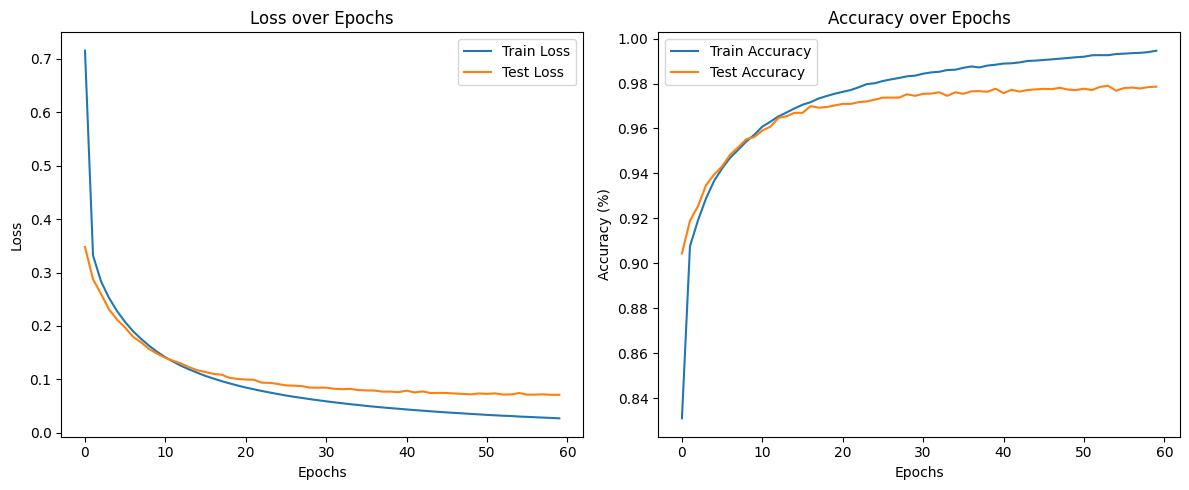

In [7]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[128]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_128, train_accuracy_list_128, test_loss_list_128, test_accuracy_list_128 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_128, test_loss_list_128, train_accuracy_list_128, test_accuracy_list_128)

cuda
203530
Training on:  cuda
Epoch [1/60], Train Loss: 0.7092, Train Accuracy: 0.8348, Test Loss: 0.3541, Test Accuracy: 0.9026


Epoch [2/60], Train Loss: 0.3331, Train Accuracy: 0.9056, Test Loss: 0.2878, Test Accuracy: 0.9206
Epoch [3/60], Train Loss: 0.2843, Train Accuracy: 0.9200, Test Loss: 0.2555, Test Accuracy: 0.9276
Epoch [4/60], Train Loss: 0.2515, Train Accuracy: 0.9291, Test Loss: 0.2315, Test Accuracy: 0.9355
Epoch [5/60], Train Loss: 0.2259, Train Accuracy: 0.9372, Test Loss: 0.2082, Test Accuracy: 0.9409
Epoch [6/60], Train Loss: 0.2045, Train Accuracy: 0.9427, Test Loss: 0.1892, Test Accuracy: 0.9457
Epoch [7/60], Train Loss: 0.1868, Train Accuracy: 0.9471, Test Loss: 0.1754, Test Accuracy: 0.9494
Epoch [8/60], Train Loss: 0.1715, Train Accuracy: 0.9518, Test Loss: 0.1625, Test Accuracy: 0.9531
Epoch [9/60], Train Loss: 0.1583, Train Accuracy: 0.9552, Test Loss: 0.1516, Test Accuracy: 0.9553
Epoch [10/60], Train Loss: 0.1468, Train Accuracy: 0.9590, Test Loss: 0.1415, Test Accuracy: 0.9572
Epoch [11/60], Train Loss: 0.1364, Train Accuracy: 0.9617, Test Loss: 0.1338, Test Accuracy: 0.9608
Epoch [1

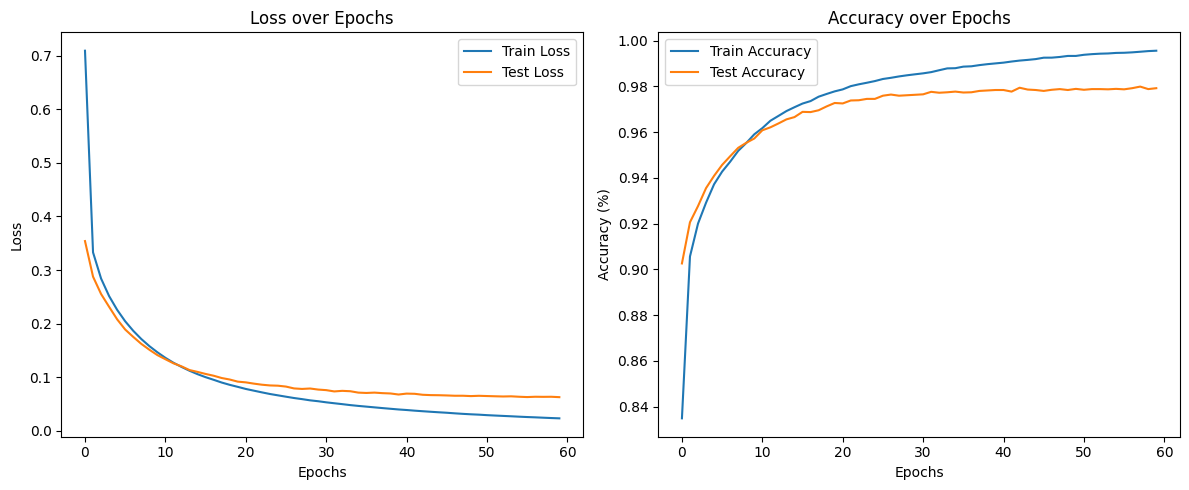

In [8]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[256]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_256, train_accuracy_list_256, test_loss_list_256, test_accuracy_list_256 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_256, test_loss_list_256, train_accuracy_list_256, test_accuracy_list_256)

cuda
55050
Training on:  cuda
Epoch [1/60], Train Loss: 0.9003, Train Accuracy: 0.7419, Test Loss: 0.3578, Test Accuracy: 0.8964
Epoch [2/60], Train Loss: 0.3310, Train Accuracy: 0.9050, Test Loss: 0.2787, Test Accuracy: 0.9206
Epoch [3/60], Train Loss: 0.2699, Train Accuracy: 0.9221, Test Loss: 0.2323, Test Accuracy: 0.9321
Epoch [4/60], Train Loss: 0.2299, Train Accuracy: 0.9336, Test Loss: 0.2239, Test Accuracy: 0.9361


Epoch [5/60], Train Loss: 0.1995, Train Accuracy: 0.9417, Test Loss: 0.1832, Test Accuracy: 0.9422
Epoch [6/60], Train Loss: 0.1766, Train Accuracy: 0.9487, Test Loss: 0.1656, Test Accuracy: 0.9509
Epoch [7/60], Train Loss: 0.1590, Train Accuracy: 0.9534, Test Loss: 0.1517, Test Accuracy: 0.9542
Epoch [8/60], Train Loss: 0.1436, Train Accuracy: 0.9579, Test Loss: 0.1428, Test Accuracy: 0.9568
Epoch [9/60], Train Loss: 0.1317, Train Accuracy: 0.9617, Test Loss: 0.1351, Test Accuracy: 0.9589
Epoch [10/60], Train Loss: 0.1204, Train Accuracy: 0.9647, Test Loss: 0.1242, Test Accuracy: 0.9614
Epoch [11/60], Train Loss: 0.1116, Train Accuracy: 0.9671, Test Loss: 0.1237, Test Accuracy: 0.9624
Epoch [12/60], Train Loss: 0.1030, Train Accuracy: 0.9698, Test Loss: 0.1124, Test Accuracy: 0.9668
Epoch [13/60], Train Loss: 0.0960, Train Accuracy: 0.9718, Test Loss: 0.1120, Test Accuracy: 0.9662
Epoch [14/60], Train Loss: 0.0899, Train Accuracy: 0.9739, Test Loss: 0.1095, Test Accuracy: 0.9655
Epoch

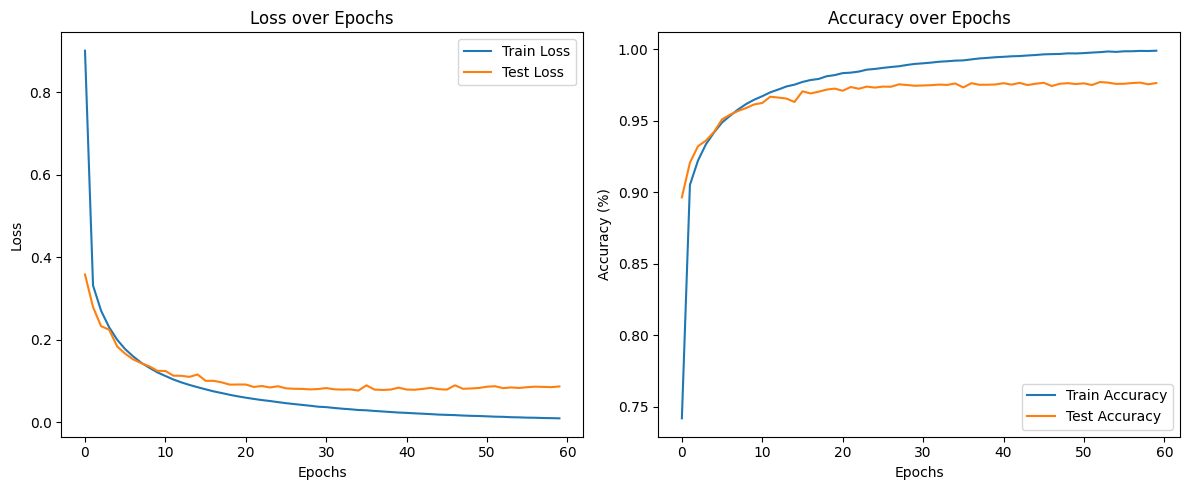

In [9]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[64,64]).to(device)
# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_64_64, train_accuracy_list_64_64, test_loss_list_64_64, test_accuracy_list_64_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_64_64, test_loss_list_64_64, train_accuracy_list_64_64, test_accuracy_list_64_64)

cuda
242762
Training on:  cuda
Epoch [1/60], Train Loss: 1.2604, Train Accuracy: 0.6213, Test Loss: 0.4045, Test Accuracy: 0.8810
Epoch [2/60], Train Loss: 0.3489, Train Accuracy: 0.8977, Test Loss: 0.2893, Test Accuracy: 0.9141
Epoch [3/60], Train Loss: 0.2500, Train Accuracy: 0.9266, Test Loss: 0.2031, Test Accuracy: 0.9397
Epoch [4/60], Train Loss: 0.1916, Train Accuracy: 0.9436, Test Loss: 0.1680, Test Accuracy: 0.9494


Epoch [5/60], Train Loss: 0.1548, Train Accuracy: 0.9551, Test Loss: 0.1707, Test Accuracy: 0.9495
Epoch [6/60], Train Loss: 0.1289, Train Accuracy: 0.9627, Test Loss: 0.1272, Test Accuracy: 0.9629
Epoch [7/60], Train Loss: 0.1098, Train Accuracy: 0.9683, Test Loss: 0.1149, Test Accuracy: 0.9660
Epoch [8/60], Train Loss: 0.0949, Train Accuracy: 0.9723, Test Loss: 0.1108, Test Accuracy: 0.9663
Epoch [9/60], Train Loss: 0.0832, Train Accuracy: 0.9760, Test Loss: 0.0988, Test Accuracy: 0.9701
Epoch [10/60], Train Loss: 0.0727, Train Accuracy: 0.9787, Test Loss: 0.0922, Test Accuracy: 0.9707
Epoch [11/60], Train Loss: 0.0639, Train Accuracy: 0.9817, Test Loss: 0.0885, Test Accuracy: 0.9732
Epoch [12/60], Train Loss: 0.0562, Train Accuracy: 0.9838, Test Loss: 0.0859, Test Accuracy: 0.9728
Epoch [13/60], Train Loss: 0.0493, Train Accuracy: 0.9859, Test Loss: 0.0858, Test Accuracy: 0.9725
Epoch [14/60], Train Loss: 0.0443, Train Accuracy: 0.9871, Test Loss: 0.0778, Test Accuracy: 0.9744
Epoch

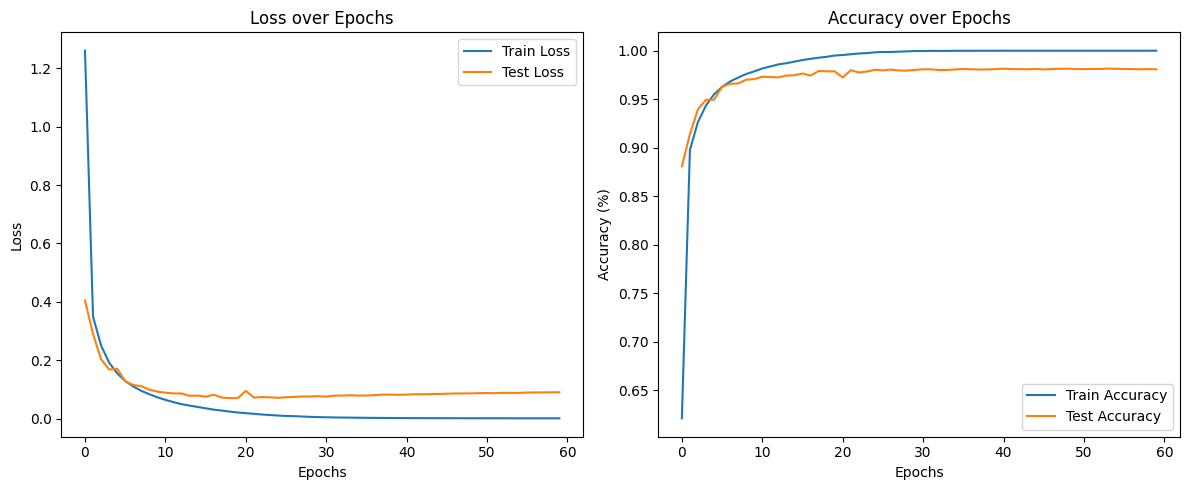

In [10]:
# 定义超参数
lr = 0.03
num_epochs = 60

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = FFN(num_inputs=28*28, num_outputs=10, num_hiddens_list=[256,128,64]).to(device)

# 模型参数量
print(sum(p.numel() for p in model.parameters()))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

train_loss_list_256_128_64, train_accuracy_list_256_128_64, test_loss_list_256_128_64, test_accuracy_list_256_128_64 = train_and_evaluate(model, train_loader, test_loader, loss_fn, optimizer, num_epochs, device)

show(train_loss_list_256_128_64, test_loss_list_256_128_64, train_accuracy_list_256_128_64, test_accuracy_list_256_128_64)

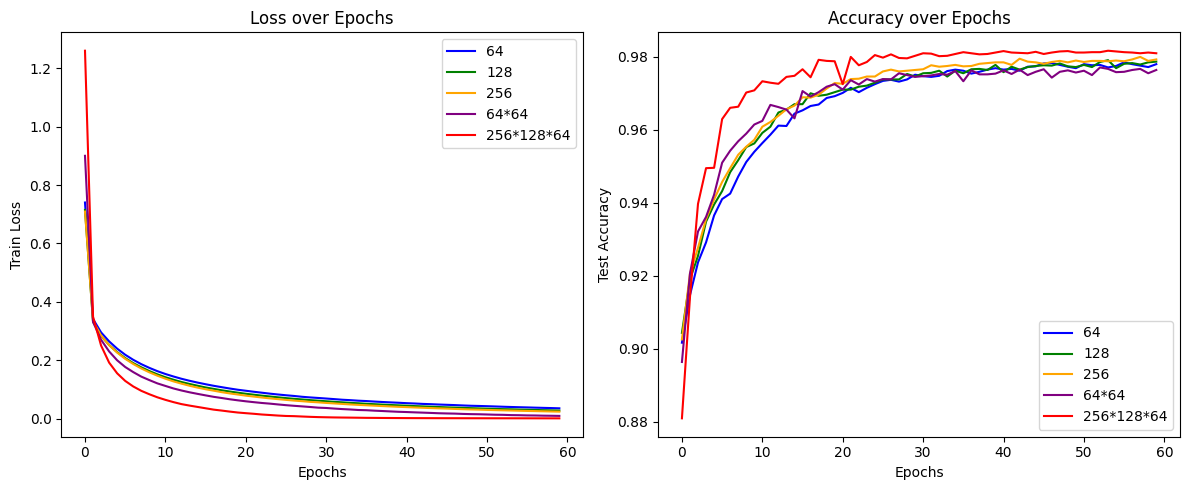

In [11]:
# 可视化结果
def show_all(train_loss_list_64, train_loss_list_128, train_loss_list_256, train_loss_list_64_64, train_loss_list_256_128_64, test_accuracy_list_64, test_accuracy_list_128, test_accuracy_list_256, test_accuracy_list_64_64, test_accuracy_list_256_128_64):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list_64, label='64', color='blue')
    plt.plot(train_loss_list_128, label='128', color='green')
    plt.plot(train_loss_list_256, label='256', color='orange')
    plt.plot(train_loss_list_64_64, label='64*64', color='purple')
    plt.plot(train_loss_list_256_128_64, label='256*128*64', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Train Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracy_list_64, label='64', color='blue')
    plt.plot(test_accuracy_list_128, label='128', color='green')
    plt.plot(test_accuracy_list_256, label='256', color='orange')
    plt.plot(test_accuracy_list_64_64, label='64*64', color='purple')
    plt.plot(test_accuracy_list_256_128_64, label='256*128*64', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
show_all(train_loss_list_64, train_loss_list_128, train_loss_list_256, train_loss_list_64_64, train_loss_list_256_128_64, test_accuracy_list_64, test_accuracy_list_128, test_accuracy_list_256, test_accuracy_list_64_64, test_accuracy_list_256_128_64)